In [26]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [27]:
df = pd.read_csv('CrimeDatabase_Extended.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   X                   5641 non-null   float64
 1   Y                   5641 non-null   float64
 2   OBJECTID            5641 non-null   int64  
 3   EVENT_UNIQUE_ID     5641 non-null   object 
 4   OCC_DATE            5641 non-null   object 
 5   OCC_YEAR            5641 non-null   int64  
 6   OCC_MONTH           5641 non-null   object 
 7   OCC_DOW             5641 non-null   object 
 8   OCC_DOY             5641 non-null   int64  
 9   OCC_DAY             5641 non-null   int64  
 10  OCC_HOUR            5641 non-null   int64  
 11  OCC_TIME_RANGE      5641 non-null   object 
 12  DIVISION            5641 non-null   object 
 13  DEATH               5641 non-null   int64  
 14  INJURIES            5641 non-null   int64  
 15  HOOD_158            5641 non-null   int64  
 16  NEIGHB

There are many date related variables in this dataset, generate a variable called month in number and remove the rest.

In [29]:
df['datetime'] = pd.to_datetime(df['OCC_DATE'])

In [30]:
df['month'] = df['datetime'].dt.month

In [31]:
df.head()

,X,Y,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_DOY,OCC_DAY,...,SOCIOLONELY,LOW_INCOME,UNAFFORDABLE_HOUSE,INADEQUATE_HOUSE,UNSUITABLE_HOUSE,DROPOUT,UNEMPLOYMENT,MALE_UNEMPLOYMENT,datetime,month
0,-79.234955,43.781528,1,GO-2004397105,2004/05/15 04:00:00+00,2004,May,Saturday,136,15,...,9.70%,27.20%,35.90%,7.80%,19.20%,20.39%,10.60%,9.80%,2004-05-15 04:00:00+00:00,5
1,-79.618218,43.733547,2,GO-2004600109,2004/07/26 04:00:00+00,2004,July,Monday,208,26,...,6.50%,15.80%,31.70%,4.70%,17.40%,21.21%,9.60%,9.20%,2004-07-26 04:00:00+00:00,7
2,-79.518759,43.769157,3,GO-2004311851,2004/05/14 04:00:00+00,2004,May,Friday,135,14,...,9.80%,33.00%,36.70%,13.60%,26.60%,37.84%,12.70%,11.30%,2004-05-14 04:00:00+00:00,5
3,-79.378870,43.660665,4,GO-2004736004,2004/12/19 05:00:00+00,2004,December,Sunday,354,19,...,39.20%,26.00%,45.10%,5.30%,8.70%,4.19%,8.50%,7.90%,2004-12-19 05:00:00+00:00,12
4,-79.212435,43.812075,5,GO-2004303455,2004/04/12 04:00:00+00,2004,April,Monday,103,12,...,5.90%,20.40%,35.70%,6.90%,17.30%,20.47%,10.50%,10.60%,2004-04-12 04:00:00+00:00,4


Since we want to analyze how does the society metrics, such as dropout rate, affect the crime rate, Group the data by HOOD_140 and month. 

In [32]:
features = ['month', 'POPULATION', 'POPDENSITY', 'POPYOUTH1524', 'POPSENIOR', 'POPMALE1529', 'HIGHRISE', 'SOCIOLONELY', 'LOW_INCOME', 'UNAFFORDABLE_HOUSE', 'INADEQUATE_HOUSE', 'UNSUITABLE_HOUSE', 
            'DROPOUT', 'UNEMPLOYMENT', 'MALE_UNEMPLOYMENT']
# POPULATION	POPDENSITY	POPYOUTH1524	POPSENIOR	POPMALE1529	HIGHRISE	SOCIOLONELY	LOW_INCOME	UNAFFORDABLE_HOUSE	INADEQUATE_HOUSE	UNSUITABLE_HOUSE	DROPOUT	UNEMPLOYMENT	MALE_UNEMPLOYMENT


grouped_df = df.groupby(['HOOD_140', 'OCC_MONTH'])[features].min()

# Reset the index to have the grouped columns as separate columns
grouped_df = grouped_df.reset_index()

# Add a new column 'count' representing the number of rows in the original dataset for each group
grouped_df['count'] = df.groupby(['HOOD_140', 'OCC_MONTH']).size().reset_index(name='count')['count']

# Display the resulting DataFrame
print(grouped_df)

      HOOD_140  OCC_MONTH  month  POPULATION  POPDENSITY POPYOUTH1524  \
0            1      April      4       33312        1117       16.35%   
1            1     August      8       33312        1117       16.35%   
2            1   December     12       33312        1117       16.35%   
3            1   February      2       33312        1117       16.35%   
4            1    January      1       33312        1117       16.35%   
...        ...        ...    ...         ...         ...          ...   
1241       140   December     12        9917        2673       10.74%   
1242       140       June      6        9917        2673       10.74%   
1243       140      March      3        9917        2673       10.74%   
1244       140        May      5        9917        2673       10.74%   
1245       140  September      9        9917        2673       10.74%   

     POPSENIOR POPMALE1529 HIGHRISE SOCIOLONELY LOW_INCOME UNAFFORDABLE_HOUSE  \
0       14.95%      13.06%   22.01%       

Reorder the dataset by month, and display the data of first neighbor hood

In [33]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
grouped_df['OCC_MONTH'] = pd.Categorical(grouped_df['OCC_MONTH'], categories=month_order, ordered=True)

grouped_df = grouped_df.sort_values(by=['HOOD_140', 'OCC_MONTH'])
grouped_df.reset_index(inplace=True)
# grouped_df = grouped_df.drop('index', axis = 1)

# print(grouped_df[grouped_df['HOOD_140'] == 1])
print(grouped_df[grouped_df['HOOD_140'] == 1])

    index  HOOD_140  OCC_MONTH  month  POPULATION  POPDENSITY POPYOUTH1524  \
0       4         1    January      1       33312        1117       16.35%   
1       3         1   February      2       33312        1117       16.35%   
2       7         1      March      3       33312        1117       16.35%   
3       0         1      April      4       33312        1117       16.35%   
4       8         1        May      5       33312        1117       16.35%   
5       6         1       June      6       33312        1117       16.35%   
6       5         1       July      7       33312        1117       16.35%   
7       1         1     August      8       33312        1117       16.35%   
8      11         1  September      9       33312        1117       16.35%   
9      10         1    October     10       33312        1117       16.35%   
10      9         1   November     11       33312        1117       16.35%   
11      2         1   December     12       33312        1117   

Add a new column called **crime rate** by **thousandth**

In [34]:
grouped_df['crime_rate'] = grouped_df['count'] / grouped_df['POPULATION'] * 1000

This following plot shows the overall distribution of the crime rate. Since we want to monitor as much variance as possible, we do not remove the outliers of crime rate.

<Axes: xlabel='crime_rate', ylabel='Count'>

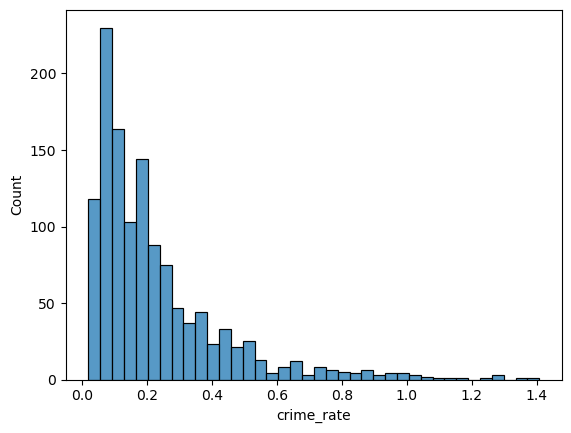

In [35]:
sns.histplot(grouped_df['crime_rate'])

The external dataset contains percentage variables. Convert them into floats for the purpose of modelling.

In [36]:
column_data_types = {
   'POPYOUTH1524' : 'float64'  ,
   'POPSENIOR' : 'float64' ,
   'POPMALE1529' : 'float64' ,
   'HIGHRISE' : 'float64' ,
   'SOCIOLONELY' : 'float64' ,
   'LOW_INCOME' : 'float64' ,
   'UNAFFORDABLE_HOUSE' : 'float64' ,
   'INADEQUATE_HOUSE' : 'float64' ,
   'UNSUITABLE_HOUSE' : 'float64' ,
   'DROPOUT' : 'float64' ,
   'UNEMPLOYMENT' : 'float64' ,
   'MALE_UNEMPLOYMENT' : 'float64'
}

for key in column_data_types.keys():
    grouped_df[key] = grouped_df[key].str.strip('%')
    grouped_df[key] = pd.to_numeric(grouped_df[key])

# grouped_df[column_data_types.keys()] = pd.to_numeric(grouped_df[column_data_types.keys()])

# Change the data type of the columns using astype()
# grouped_df = grouped_df.astype(column_data_types)
print(grouped_df.dtypes)

index                    int64
HOOD_140                 int64
OCC_MONTH             category
month                    int64
POPULATION               int64
POPDENSITY               int64
POPYOUTH1524           float64
POPSENIOR              float64
POPMALE1529            float64
HIGHRISE               float64
SOCIOLONELY            float64
LOW_INCOME             float64
UNAFFORDABLE_HOUSE     float64
INADEQUATE_HOUSE       float64
UNSUITABLE_HOUSE       float64
DROPOUT                float64
UNEMPLOYMENT           float64
MALE_UNEMPLOYMENT      float64
count                    int64
crime_rate             float64
dtype: object


In [37]:
# This code snippet acts as a demo of data visualization

'''hoods = grouped_df['HOOD_140'].unique()
df_hoods = grouped_df
hood_crime_rate = {}
# fill the dictionary with hood number and crime rates
for i in hoods:
    hood_crime_rate[i] = np.sum(df_hoods[df_hoods['HOOD_140'] == i]['crime_rate'])

df_hoods['hood_crime_rate'] = df_hoods['HOOD_140'].map(hood_crime_rate)
# now we have the total crime rate of hood_140'''

"hoods = grouped_df['HOOD_140'].unique()\ndf_hoods = grouped_df\nhood_crime_rate = {}\n# fill the dictionary with hood number and crime rates\nfor i in hoods:\n    hood_crime_rate[i] = np.sum(df_hoods[df_hoods['HOOD_140'] == i]['crime_rate'])\n\ndf_hoods['hood_crime_rate'] = df_hoods['HOOD_140'].map(hood_crime_rate)\n# now we have the total crime rate of hood_140"

In [38]:
# plot crime rate to DROPOUT
# sns.lmplot(x = 'hood_crime_rate', y = 'DROPOUT', data = df_hoods)

**OLS** and summary function are used to generate t and P value of variables. A low P and high t indicates that it is significant to crime rate. Low significant variables can be removed for efficiency and accuracy.

In [39]:
results = ols("crime_rate ~ OCC_MONTH +  POPDENSITY +POPYOUTH1524 +POPSENIOR +POPMALE1529 +HIGHRISE+SOCIOLONELY+ LOW_INCOME+ UNAFFORDABLE_HOUSE + INADEQUATE_HOUSE + UNSUITABLE_HOUSE + DROPOUT + UNEMPLOYMENT + MALE_UNEMPLOYMENT", data=grouped_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             crime_rate   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     51.52
Date:                Sun, 23 Jul 2023   Prob (F-statistic):          2.27e-166
Time:                        01:59:35   Log-Likelihood:                 619.15
No. Observations:                1246   AIC:                            -1188.
Df Residuals:                    1221   BIC:                            -1060.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

## Modelling

Begin by using the simplest **OLS regression** model with reduced multicolinearity and variables that are significant.

In [40]:
# Modify the original dataset for modelling with fewer but more interpretable variables
df_ols = grouped_df
lamb = lambda x : 1 if (grouped_df['month'] == 7 or grouped_df['month'] == 8 or grouped_df['month'] == 9) else 0
def peak(x):
    if x == 7 or x == 8 or x == 9:
        return 1
    else: return 0


In [41]:
df_ols['PEAK_GUNSEASON'] = df_ols['month'].apply(peak)
df_ols.head()


,index,HOOD_140,OCC_MONTH,month,POPULATION,POPDENSITY,POPYOUTH1524,POPSENIOR,POPMALE1529,HIGHRISE,...,LOW_INCOME,UNAFFORDABLE_HOUSE,INADEQUATE_HOUSE,UNSUITABLE_HOUSE,DROPOUT,UNEMPLOYMENT,MALE_UNEMPLOYMENT,count,crime_rate,PEAK_GUNSEASON
0,4,1,January,1,33312,1117,16.35,14.95,13.06,22.01,...,15.8,31.7,4.7,17.4,21.21,9.6,9.2,12,0.360231,0
1,3,1,February,2,33312,1117,16.35,14.95,13.06,22.01,...,15.8,31.7,4.7,17.4,21.21,9.6,9.2,7,0.210134,0
2,7,1,March,3,33312,1117,16.35,14.95,13.06,22.01,...,15.8,31.7,4.7,17.4,21.21,9.6,9.2,5,0.150096,0
3,0,1,April,4,33312,1117,16.35,14.95,13.06,22.01,...,15.8,31.7,4.7,17.4,21.21,9.6,9.2,13,0.390250,0
4,8,1,May,5,33312,1117,16.35,14.95,13.06,22.01,...,15.8,31.7,4.7,17.4,21.21,9.6,9.2,14,0.420269,0


In [42]:
results = ols("crime_rate ~ PEAK_GUNSEASON + POPDENSITY + POPMALE1529 + HIGHRISE + LOW_INCOME+ UNAFFORDABLE_HOUSE + DROPOUT", data=grouped_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             crime_rate   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     139.6
Date:                Sun, 23 Jul 2023   Prob (F-statistic):          1.52e-151
Time:                        01:59:35   Log-Likelihood:                 545.81
No. Observations:                1246   AIC:                            -1076.
Df Residuals:                    1238   BIC:                            -1035.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0480      0.036      1.322      0.186      -0.023       0.119
PEAK_GUNSEASON         0.0483      0.010      4.759      0.000       0.028       0.068
POPDENSITY         -1.187e-06   9.88e-07     -1.201      0.230   -3.13e-06    7.52e-07
POPMALE1529            0.0229      0.003      9.082      0.000       0.018       0.028
HIGHRISE               0.0015      0.000      4.787      0.000       0.001       0.002
LOW_INCOME             0.0114      0.001     10.172      0.000       0.009       0.014
UNAFFORDABLE_HOUSE    -0.0162      0.001    -12.446      0.000      -0.019      -0.014
DROPOUT                0.0119      0.001     16.087      0.000       0.010       0.013
==============================================================================
Omnibus:                      343.105   Durbin-Watson:                   1.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1231.606
Skew:                           1.307   Prob(JB):                    3.63e-268
Kurtosis:                       7.110   Cond. No.                     6.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
pred_vals = results.predict(df_ols[['PEAK_GUNSEASON', 'POPDENSITY', 'POPMALE1529', 'HIGHRISE', 'LOW_INCOME', 'UNAFFORDABLE_HOUSE', 'DROPOUT']])
print('MSE: ', np.sqrt(mean_squared_error(y_pred = pred_vals, y_true = df_ols['crime_rate'])))
print('R2 Score: ', r2_score(y_pred = pred_vals, y_true = df_ols['crime_rate']))

MSE:  0.15614255563721796
R2 Score:  0.4410841266021447


Adopting the result from ols summary, only the significant variables are kept.

In [44]:
categorical_features = ['HOOD_140', 'OCC_MONTH']
numerical_features = ['POPDENSITY', 'POPYOUTH1524', 'POPMALE1529',
 'HIGHRISE', 'SOCIOLONELY', 'LOW_INCOME', 'UNAFFORDABLE_HOUSE', 'INADEQUATE_HOUSE',
 'DROPOUT', 'UNEMPLOYMENT', 'MALE_UNEMPLOYMENT']
target = 'crime_rate'

In [45]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(grouped_df[categorical_features + numerical_features], grouped_df[target], 
    test_size = 0.3, random_state = 2345)

In [46]:
cat_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
# simple imputer fills missing value with average, KNNImputer, etc
num_transformer = Pipeline(steps = [('scaler', MinMaxScaler())])
# minmax transform the data between 0 and 1

# building processor
preprocessor = ColumnTransformer(transformers = [('cat', cat_transformer, categorical_features),
                                                 ('num', num_transformer, numerical_features)])

In [47]:
ridge_regression = Pipeline(steps = [('preprocessor', preprocessor),
                                      ('regressor', Ridge(alpha = 0.01))
                                      ])
# higher alpha, more penalty
# how to know which hyper param is the best? hyper param tuning
ridge_regression.fit(X_train, y_train)
pred_ridge = ridge_regression.predict(X_test)
print('MSE value: ', np.sqrt(mean_squared_error(pred_ridge, y_test)))
print('R2 value: ', r2_score(pred_ridge, y_test))

MSE value:  0.12578962495700757
R2 value:  0.5251108097836035


In [48]:
lasso_regression = Pipeline(steps = [('preprocessor', preprocessor),
                                      ('regressor', Lasso(alpha = 0.000000001))
                                      ])
lasso_regression.fit(X_train, y_train)
pred_ridge = lasso_regression.predict(X_test)
print('MSE value: ', np.sqrt(mean_squared_error(pred_ridge, y_test)))
print('R2 value: ', r2_score(pred_ridge, y_test))

MSE value:  0.12593871423577624
R2 value:  0.5212380654066782


c:\Users\13343\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.830000500585335, tolerance: 0.00393020567291922
  model = cd_fast.sparse_enet_coordinate_descent(


Display the coefficient generated by Lasso and Ridge regression. The coeffs can be interpreted for the influence on crime rate.

In [49]:
# RIDGE coefficients

feature_names = X_train.columns

# Getting the coefficients
coefficients = ridge_regression.named_steps['regressor'].coef_

# # Pair each feature name with its coefficient
# feature_coef = list(zip(feature_names, coefficients))

# # Filter only those features which have non-zero coefficients
# retained_features = [pair for pair in feature_coef if pair[1] != 0]

# print(retained_features)

In [50]:
# LASSO coefficients

feature_names = X_train.columns

# Getting the coefficients
coefficients = lasso_regression.named_steps['regressor'].coef_



# # Pair each feature name with its coefficient
# feature_coef = list(zip(feature_names, coefficients))

# # Filter only those features which have non-zero coefficients
# retained_features = [pair for pair in feature_coef if pair[1] != 0]

# print(retained_features)

### Analyzing coefficients and features

In [51]:
# Extract the processed variable names from the pipeline
def get_transformer_feature_names(column_transformer):
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names_out(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

# Change this line and you can get the variables from different pipelines.
feature_names = get_transformer_feature_names(lasso_regression.named_steps['preprocessor'])
print(feature_names)


['HOOD_140_1', 'HOOD_140_2', 'HOOD_140_3', 'HOOD_140_4', 'HOOD_140_5', 'HOOD_140_6', 'HOOD_140_7', 'HOOD_140_8', 'HOOD_140_9', 'HOOD_140_10', 'HOOD_140_11', 'HOOD_140_12', 'HOOD_140_13', 'HOOD_140_14', 'HOOD_140_15', 'HOOD_140_16', 'HOOD_140_17', 'HOOD_140_18', 'HOOD_140_19', 'HOOD_140_20', 'HOOD_140_21', 'HOOD_140_22', 'HOOD_140_23', 'HOOD_140_24', 'HOOD_140_25', 'HOOD_140_26', 'HOOD_140_27', 'HOOD_140_28', 'HOOD_140_29', 'HOOD_140_30', 'HOOD_140_31', 'HOOD_140_32', 'HOOD_140_33', 'HOOD_140_34', 'HOOD_140_35', 'HOOD_140_36', 'HOOD_140_37', 'HOOD_140_38', 'HOOD_140_39', 'HOOD_140_40', 'HOOD_140_41', 'HOOD_140_42', 'HOOD_140_43', 'HOOD_140_44', 'HOOD_140_45', 'HOOD_140_46', 'HOOD_140_47', 'HOOD_140_48', 'HOOD_140_49', 'HOOD_140_50', 'HOOD_140_51', 'HOOD_140_52', 'HOOD_140_53', 'HOOD_140_54', 'HOOD_140_55', 'HOOD_140_56', 'HOOD_140_57', 'HOOD_140_58', 'HOOD_140_59', 'HOOD_140_60', 'HOOD_140_61', 'HOOD_140_62', 'HOOD_140_63', 'HOOD_140_64', 'HOOD_140_65', 'HOOD_140_66', 'HOOD_140_67', 'HO

Transformed variables and coefficients from selected model

In [52]:
for i in range(len(feature_names)):
    print(feature_names[i], ': ', coefficients[i])

HOOD_140_1 :  0.1080436938662824
HOOD_140_2 :  0.25113440124888714
HOOD_140_3 :  0.012733256291014227
HOOD_140_4 :  0.07252678880670414
HOOD_140_5 :  0.32483722951048577
HOOD_140_6 :  0.12219406055179786
HOOD_140_7 :  -0.041184096387383094
HOOD_140_8 :  0.0030576938073306735
HOOD_140_9 :  -0.10280835751644143
HOOD_140_10 :  -0.10172730045480903
HOOD_140_11 :  -0.08051294280329893
HOOD_140_12 :  -0.14847270069781546
HOOD_140_13 :  0.0005019015087910228
HOOD_140_14 :  -0.12099558064111442
HOOD_140_15 :  0.1379653090973642
HOOD_140_16 :  -0.14727669522506773
HOOD_140_17 :  -0.1427408877058657
HOOD_140_18 :  0.010787672424712173
HOOD_140_19 :  -0.03961807857131321
HOOD_140_20 :  -0.05867440495851132
HOOD_140_21 :  0.6162122667612968
HOOD_140_22 :  0.1682071385500465
HOOD_140_23 :  0.046732630719433836
HOOD_140_24 :  0.539954143033956
HOOD_140_25 :  0.571167206400633
HOOD_140_26 :  0.12284033339252899
HOOD_140_27 :  0.14301188635853218
HOOD_140_28 :  0.544885261108464
HOOD_140_29 :  -0.0003

In [53]:
original_data = X_test
# print(original_data.head())
print("original rate: ", np.median(lasso_regression.predict(original_data)))

test_data = original_data
test_data['DROPOUT'] = test_data['DROPOUT'] - 15
# print(test_data.head())
print("reduce 15 percent dropout rate: ", np.median(lasso_regression.predict(test_data)))

test_data = original_data
test_data['UNEMPLOYMENT'] = test_data['UNEMPLOYMENT'] - 15
# print(test_data.head())
print("reduce 15 percent unemployment rate: ", np.median(lasso_regression.predict(test_data)))

original rate:  0.17196247497667416
reduce 15 percent dropout rate:  0.17113773005316207
reduce 15 percent unemployment rate:  0.16074127772014957


In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

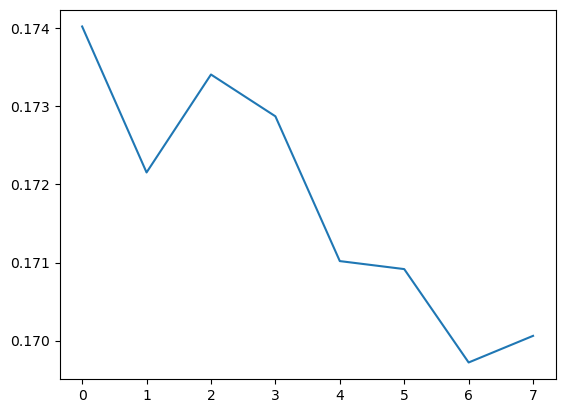

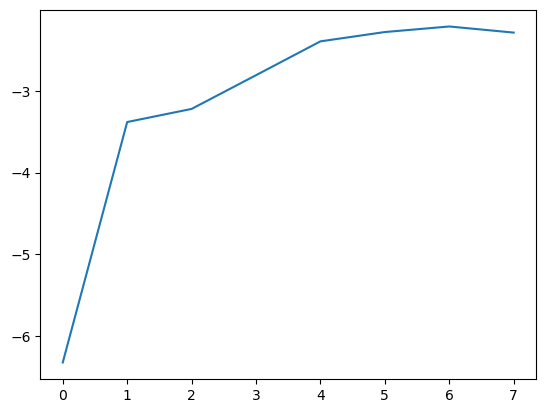

In [60]:
MSE_score = []
R2_score = []
for i in [2,3,5,7,9,11,13,15]:
    regr = Pipeline(steps = [('preprocessor', preprocessor),
                                        ('regressor', RandomForestRegressor(max_depth=i, random_state=123))
                                        ])
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    MSE_score.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    R2_score.append(r2_score(y_pred, y_test))

plt.figure()
plt.plot(MSE_score)
plt.figure()
plt.plot(R2_score)

In [61]:
print(MSE_score[6])

0.16971959972246775


Random forest regressor: in the 5th iteration, with the depth of 11, it achieves the best performance and lowest error of 0.1697.